![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+Optimization&file=Vertex+AI+Vizier+-+Getting+Started.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Optimization/Vertex%20AI%20Vizier%20-%20Getting%20Started.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520Optimization%2FVertex%2520AI%2520Vizier%2520-%2520Getting%2520Started.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Optimization/Vertex%20AI%20Vizier%20-%20Getting%20Started.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20Optimization/Vertex%20AI%20Vizier%20-%20Getting%20Started.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Vertex AI Vizier - Getting Started

Our work is filled with hidden processes that impact what we measure:
- ML Hyperparameters
    - Best setting for hyperparameters to optimize accuracy (and minimize complexity...)
- Model Architecture
    - Best model type and setting for a given dataset
- Systems Design
    - Maximize speed while minimizing resource consumption
- Business Insights - The Pareto Frontier
    - optimal solution for minimizing cost while maximizing revenue

We usually have some set of items we can controls: knobs, levers, parameters.  How do we find the optimal setting of these to achieve an objective?  What if we want to balance multiple objectives?  And, what happens if we are also have constraints/thresholds we cannot exceed on some metrics?  

This is where [Vertex AI Vizier](https://cloud.google.com/vertex-ai/docs/vizier/overview) can help.  With this API you define a study with the parameters and metrics along with any constraints.  Then you interact with the study by request suggestions (trials) and then returns the metrics for the suggested parameters.  Each successive suggestion gets closer to an optimal goal!

This workflow will take a not so hidden process - actually three of them.  The processes will be visualized against the knobs we can control and then the Vizier service will be used to find an optimal setting for the knobs.

Let's jump in and see how Vizier works!

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('numpy', 'numpy'),
    ('plotly', 'plotly'),
    ('kaleido', 'kaleido'),
    ('scipy', 'scipy'),
    ('matplotlib', 'matplotlib'),
    ('google.cloud.aiplatform', 'google-cloud-aiplatform')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [4]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [5]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [6]:
REGION = 'us-central1'
SERIES = 'applied-optimizaton'
EXPERIMENT = 'vizier-getting-started'

packages:

In [7]:
import os, json

from google.cloud import aiplatform
from google.cloud import aiplatform_v1

import scipy.optimize

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

clients:

The [Vizier Clients](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.vizier_service).

In [8]:
vizier = aiplatform.gapic.VizierServiceClient(
    client_options = {"api_endpoint" : f"{REGION}-aiplatform.googleapis.com"}
)

Parameters:

In [9]:
PARENT = f"projects/{PROJECT_ID}/locations/{REGION}"
DIR = f"files/{EXPERIMENT}"

Environment:

In [10]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## The Problem

In real-world scenarios we have parameters we can control or atleast monitor.  But we don't always know the underlying system.  Why does this matter?  Well, that leaves us guessing what the best parameter values are to meet an objective, like minimum or maximum output.  Some scenarios like this:
- ML Hyperparameters
    - Best setting for hyperparameters to optimize accuracy (and minimize complexity...)
- AutoML
    - Best model type and setting for a given dataset
- System Design
    - Maximize speed while minimizing resource consumption
- Hardware Design
    - Minimize power consumption while maximizing performance
- Business Insights - The Pareto Frontier
    - optimal solution for minimizing cost while maximizing revenue

### The Knobs

Imagine we have two knobs (or 100) that can be adjusted:
- `knob_1` is [-5, 5]
- `knob_2` is [-5, 5]

In [11]:
knob_1 = np.arange(-5, 5, 0.1)
knob_2 = np.arange(-5, 5, 0.1)

### The Hidden Process(es)

We don't know the hidden processes but image we do in this case.  Here, functions defines a process.  If we knew these function then we could use calculus or numerical optimization to find the minimum/maximum values - but remember we dont know these functions.

In [12]:
def hidden_1(knob_1, knob_2):
    """
    This function has a global maximum and several local maxima.
    """
    x = knob_1
    y = knob_2
    return -(x**2 + y**2) * np.sin(x) * np.cos(0.5 * y) + 2

def hidden_2(knob_1, knob_2):
    """
    This function has a global maximum and a few local maxima.
    """
    x = knob_1
    y = knob_2
    return -(x**2 + y**2) * np.cos(0.5 * x) * np.sin(y) - 1

def hidden_3(knob_1, knob_2):
    """
    This function has a global minimum and several local minima.
    """
    x = knob_1
    y = knob_2
    return (x**2 + y**2) * np.sin(x) * np.sin(y)

### Numerical Optimization: What We Wish We Could Do In Real Life!

In [13]:
answer_1 = scipy.optimize.minimize(lambda x: hidden_1(x[0], x[1]), x0 = [0, 0], bounds = [(-5, 5), (-5, 5)]).fun
answer_1

2.0

In [14]:
answer_2 = -1*scipy.optimize.minimize(lambda x: -1*hidden_2(x[0], x[1]), x0 = [0, 0], bounds = [(-5, 5), (-5, 5)]).fun
answer_2

-1.0

In [15]:
answer_3 = -1*scipy.optimize.minimize(lambda x: -1*hidden_3(x[0], x[1]), x0 = [0, 0], bounds = [(-5, 5), (-5, 5)]).fun
answer_3

0.0

### Visualize The Hidden Process(es): If Only We Could!

In [16]:
# Create the meshgrid
X, Y = np.meshgrid(knob_1, knob_2)

# Create the surface plots
surface1 = go.Surface(x=X, y=Y, z=hidden_1(X, Y), colorscale="reds", name="Hidden 1 (Min)", visible=True, showscale=False)
surface2 = go.Surface(x=X, y=Y, z=hidden_2(X, Y), colorscale="blues", name="Hidden 2 (Max)", visible=True, showscale=False)
surface3 = go.Surface(x=X, y=Y, z=hidden_3(X, Y), colorscale="greens", name="Hidden 3 (Max)", visible=True, showscale=False)

In [ ]:
# Create the figure with subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"is_3d": True}, {"is_3d": True}, {"is_3d": True}]],
    subplot_titles=("Hidden 1 (Min)", "Hidden 2 (Max)", "Hidden 3 (Max)"),
)

# Create the surface plots and add them to the subplots
fig.add_trace(surface1, row=1, col=1)
fig.add_trace(surface2, row=1, col=2)
fig.add_trace(surface3, row=1, col=3)

# Update layout to add color bars to each subplot
fig.update_layout(
    scene1=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    scene2=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    scene3=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    autosize=False,
    width=1200,  # Adjust width as needed
    height=500,  # Adjust height as needed
)

# Display the plot
fig.show()

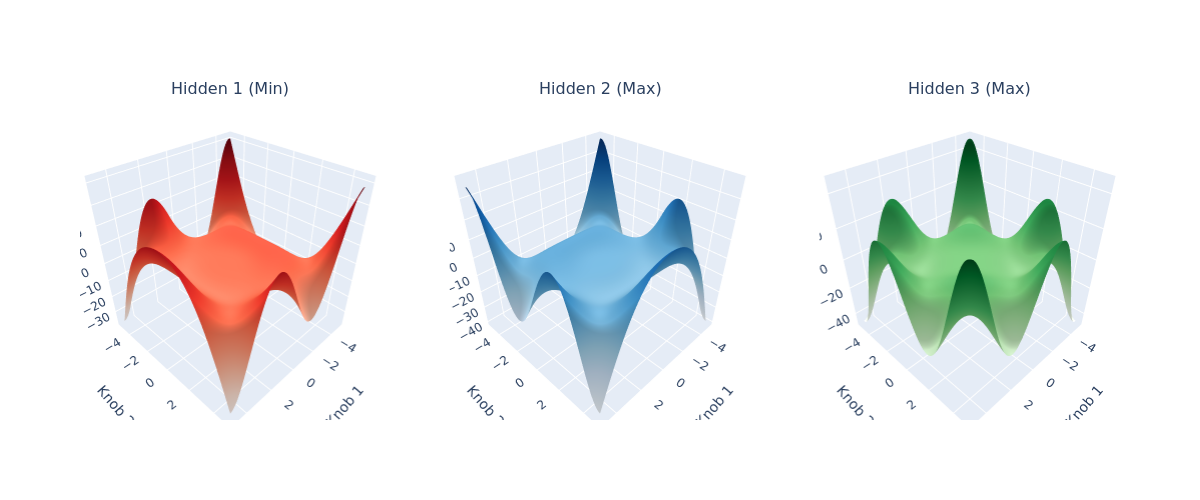

In [18]:
fig.show('png')

### Safe Optimization

Some metrics might need constraints because of values that are not desirable - unsafe.  Think about profit as a metric, you might not want a negative outcome.  Vizier allows setting safety thresholds along with the percentage of time it is ok to explore beyond the threshold.  Vizier will build a model that constrains the parameter search to stay on the desired side of the safety threshold.  

Looking at green here, we might want to stay at or above 0.  Update the plots to illustrate this by color coding value below 0 on a grey scale:

In [19]:
get_z = hidden_3(X, Y)
surface3 = go.Surface(x=X, y=Y, z=np.where(get_z >= 0, get_z, np.nan), colorscale="greens", cmin=np.min(get_z), cmax=np.max(get_z), name="Hidden 3 (Max)", visible=True, showscale=False)
surface3b = go.Surface(x=X, y=Y, z=np.where(get_z < 0, get_z, np.nan), colorscale="greys", cmin=np.min(get_z), cmax=np.max(get_z), name="Hidden 3 (Max)", visible=True, showscale=False)

In [ ]:
# Create the figure with subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"is_3d": True}, {"is_3d": True}, {"is_3d": True}]],
    subplot_titles=("Hidden 1 (Min)", "Hidden 2 (Max)", "Hidden 3 (Max)"),
)

# Create the surface plots and add them to the subplots
fig.add_trace(surface1, row=1, col=1)
fig.add_trace(surface2, row=1, col=2)
fig.add_trace(surface3, row=1, col=3)
fig.add_trace(surface3b, row=1, col=3)

# Update layout to add color bars to each subplot
fig.update_layout(
    scene1=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    scene2=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    scene3=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    autosize=False,
    width=1200,  # Adjust width as needed
    height=500,  # Adjust height as needed
)

# Display the plot
fig.show()

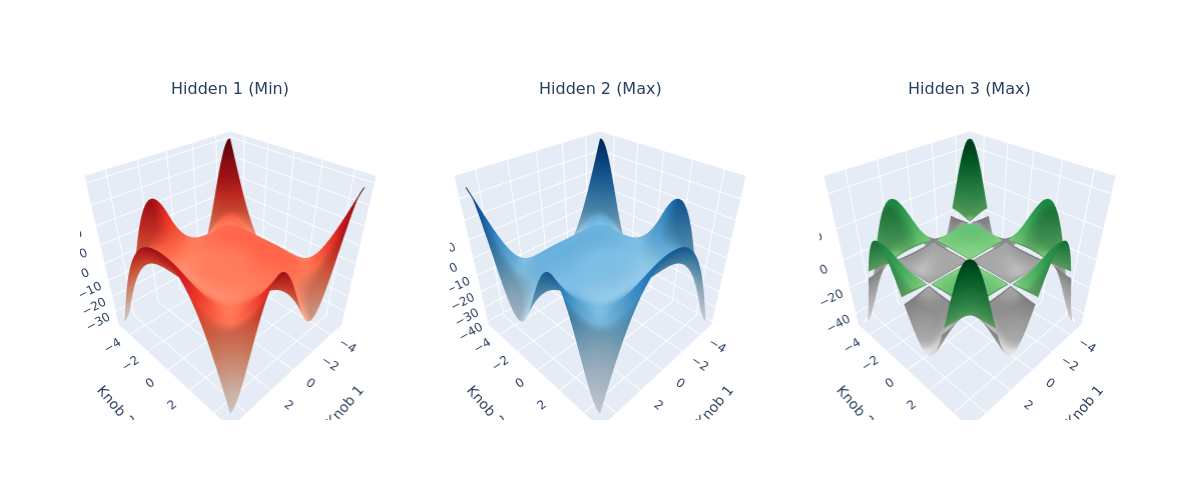

In [21]:
fig.show('png')

### Competing Objectives

To make things more difficult we might even need to simultaneously balance these hidden systems to find a combined minimum and maximum.   
Once these process are overlaid it show that their is a lot of nuiance in the combine solution:

In [ ]:
# Create the figure and add the surfaces
fig = go.Figure(data=[surface1, surface2, surface3, surface3b])

# Add dropdown menu for toggling visibility
fig.update_layout(
    showlegend=False,  # Hide the legend
    autosize=False,
    width=1200,
    height=800,
    scene=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    title="Interactive Plot Competing Hidden Processes<br><sup>Red (Min), Blue (Max), Green (Max)</sup>",    
)

# Display the plot
fig.show()

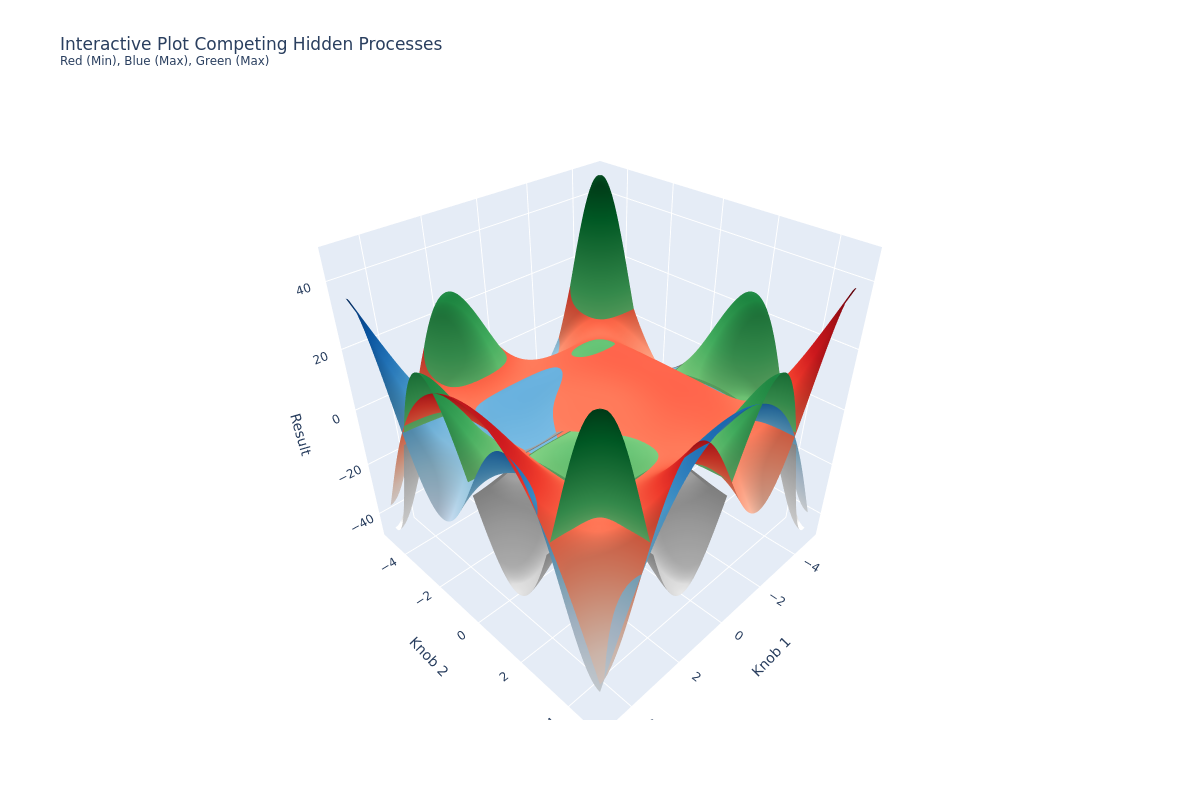

In [23]:
fig.show('png')

### Brute Force Exploration

We have the knobs that we can adjust.  Maybe we can 'get lucky' and find a good answer by adjusting them?

Build a function to evaluate parameter suggestions:

In [24]:
def process_evaluation(knob_1, knob_2):
    results = []
    results.append(dict(metric_id = 'red', value = hidden_1(knob_1, knob_2)))
    results.append(dict(metric_id = 'blue', value = hidden_2(knob_1, knob_2)))
    results.append(dict(metric_id = 'green', value = hidden_3(knob_1, knob_2)))
    return results

In [25]:
process_evaluation(0, 0)

[{'metric_id': 'red', 'value': 2.0},
 {'metric_id': 'blue', 'value': -1.0},
 {'metric_id': 'green', 'value': 0.0}]

---
## Vertex AI Vizier: Intelligent Exploration

### Design A Study

Studies are are defined by a [StudySpec](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.types.StudySpec):
- [parameters](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.types.StudySpec.ParameterSpec)
- [metrics](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.types.StudySpec.MetricSpec)
- [algorithm](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.types.StudySpec.Algorithm) (Vizier, Grid, Random)
- more:
    - study stopping configuration
    - observation noise (if objective is reproducible (LOW) or variable (HIGH))
    - measurement selection type (last(default) or best)
    - stop spec: decay curve, median, convex

Define the two parameters and three metrics including a saftey threshold for the green metric to prevent exploring value that endup below 0:



In [26]:
parameter_spec = [
    dict(
        parameter_id = 'knob_1',
        double_value_spec = dict(min_value = np.min(knob_1), max_value = np.max(knob_1))
    ),
    dict(
        parameter_id = 'knob_2',
        double_value_spec = dict(min_value = np.min(knob_2), max_value = np.max(knob_2))
    )
]

In [27]:
metric_spec = [
    dict(metric_id = 'red', goal = 'MINIMIZE'),
    dict(metric_id = 'blue', goal = 'MAXIMIZE'),
    dict(
        metric_id = 'green',
        goal = 'MAXIMIZE',
        safety_config = dict(safety_threshold = 0, desired_min_safe_trials_fraction = 0.9)
    ),
]

In [28]:
study_spec = dict(
    display_name = f'{SERIES}-{EXPERIMENT}'.replace('-', '_'),
    study_spec = dict(
        algorithm = 'ALGORITHM_UNSPECIFIED',
        parameters = parameter_spec,
        metrics = metric_spec
    )
)

In [29]:
study_spec

{'display_name': 'applied_optimizaton_vizier_getting_started',
 'study_spec': {'algorithm': 'ALGORITHM_UNSPECIFIED',
  'parameters': [{'parameter_id': 'knob_1',
    'double_value_spec': {'min_value': -5.0, 'max_value': 4.899999999999965}},
   {'parameter_id': 'knob_2',
    'double_value_spec': {'min_value': -5.0, 'max_value': 4.899999999999965}}],
  'metrics': [{'metric_id': 'red', 'goal': 'MINIMIZE'},
   {'metric_id': 'blue', 'goal': 'MAXIMIZE'},
   {'metric_id': 'green',
    'goal': 'MAXIMIZE',
    'safety_config': {'safety_threshold': 0,
     'desired_min_safe_trials_fraction': 0.9}}]}}

### Create A Vertex AI Vizier Study

Check for existing study:

In [30]:
try:
    study = vizier.lookup_study(dict(parent = PARENT, display_name = study_spec['display_name']))
except Exception:
    study = None

Create (or Retrieve) study:

In [31]:
if not study:
    study = vizier.create_study(parent = PARENT, study = study_spec)
study.name, study.display_name, study.state, study.create_time.strftime("%m-%d-%Y-%H:%M:%S")

('projects/1026793852137/locations/us-central1/studies/2929393184535',
 'applied_optimizaton_vizier_getting_started',
 <State.ACTIVE: 1>,
 '10-08-2024-00:26:26')

View the study in the console:

In [32]:
print(f"https://console.cloud.google.com/vertex-ai/experiments/locations/{REGION}/studies/{study.name.split('/')[-1]}?project={PROJECT_ID}")

https://console.cloud.google.com/vertex-ai/experiments/locations/us-central1/studies/2929393184535?project=statmike-mlops-349915


### Load Past Trials

You can start Vizier from scratch and it will suggest an initial guess and then learn from succesive trials. If you already have known metrics values for some parameter settings then you can load these to help Vizier get started.  

This section loads 15 random parameters sets with evalaution results:

In [33]:
for trial in range(15):
    # get a random parameter settings
    try_knob_1 = np.random.uniform(low=np.min(knob_1), high=np.max(knob_1))
    try_knob_2 = np.random.uniform(low=np.min(knob_2), high=np.max(knob_2))
    
    # evaluation the parameters
    try_eval = process_evaluation(try_knob_1, try_knob_2)
    
    # register the evaluation as a seed trial in Vizier
    add_trial = vizier.create_trial(
        dict(
            parent = study.name,
            trial = dict(
                state = aiplatform_v1.Trial.State.SUCCEEDED,
                parameters = [dict(parameter_id = "knob_1", value = try_knob_1), dict(parameter_id = 'knob_2', value = try_knob_2)],
                final_measurement = dict(metrics = try_eval)
            )
        )
    )

How many trials are registered?

In [34]:
n_trials = len(vizier.list_trials(dict(parent = study.name)).trials)
n_trials

15

### Get A Suggestion: Trial

In [35]:
suggestions = vizier.suggest_trials(
    dict(
        parent = study.name,
        suggestion_count = 1,
        client_id = 'client_1'
    )
).result()

Format suggestions:

In [36]:
trial_inputs = []
for s in suggestions.trials:
    parms = dict(name = s.name)
    for p in s.parameters:
        parms[p.parameter_id] = p.value
    trial_inputs.append(parms)
trial_inputs

[{'name': 'projects/1026793852137/locations/us-central1/studies/2929393184535/trials/16',
  'knob_1': 2.079037762161403,
  'knob_2': -4.702727465270137}]

### Evaluate The Trial Suggestions

Turn the knobs to the suggestion and measure the outcome!  In this case we need the output from each function representing the hidden process to return to the Vizier service as measurements.

In [37]:
trial_results = [
    dict(
        name = trial['name'],
        final_measurement = dict(
            metrics = process_evaluation(trial['knob_1'], trial['knob_2'])
        )
    ) for trial in trial_inputs
]
trial_results

[{'name': 'projects/1026793852137/locations/us-central1/studies/2929393184535/trials/16',
  'final_measurement': {'metrics': [{'metric_id': 'red',
     'value': 18.252479363536008},
    {'metric_id': 'blue', 'value': -14.393816197254505},
    {'metric_id': 'green', 'value': 23.095240556093415}]}}]

### Return The Measurement To The Study

In [38]:
responses = [vizier.complete_trial(trial) for trial in trial_results]

In [39]:
responses[0].state

<State.SUCCEEDED: 4>

### How Many Trials Have Been Evaluated?

The total evaluations is not the combination of the 25 seed trials and the suggestion that was evaluated from Vizier:

In [40]:
n_trials = len(vizier.list_trials(dict(parent = study.name)).trials)
n_trials

16

### Iterate Up To 50 Trials: Batches of 5


In [41]:
trial_count = 50
batch_size = 5

while n_trials < trial_count:
    # get suggestion(s)
    suggestions = vizier.suggest_trials(
        dict(
            parent = study.name,
            suggestion_count = batch_size,
            client_id = 'client_1'
        )
    ).result()

    # format suggestion
    trial_inputs = []
    for s in suggestions.trials:
        parms = dict(name = s.name)
        for p in s.parameters:
            parms[p.parameter_id] = p.value
        trial_inputs.append(parms)

    # evaluate suggestion
    trial_results = [
        dict(
            name = trial['name'],
            final_measurement = dict(
                metrics = process_evaluation(trial['knob_1'], trial['knob_2'])
            )
        ) for trial in trial_inputs
    ]

    # register result to study
    responses = [vizier.complete_trial(trial) for trial in trial_results]

    # increment counter
    n_trials += batch_size

### Get Optimal Trials

In [42]:
optimal_trials = vizier.list_optimal_trials(dict(parent = study.name))
# filter to under first 100 trial - in case this has been run before
optimal_trials = [trial for trial in optimal_trials.optimal_trials if int(trial.name.split('/')[-1]) <= 50]

In [43]:
len(optimal_trials)

1

In [44]:
optimal_values = dict(
    names = [trial.name for trial in optimal_trials],
    knob_1 = [trial.parameters[0].value for trial in optimal_trials],
    knob_2 = [trial.parameters[1].value  for trial in optimal_trials],
    red = [trial.final_measurement.metrics[0].value for trial in optimal_trials],
    blue = [trial.final_measurement.metrics[1].value for trial in optimal_trials],
    green = [trial.final_measurement.metrics[2].value for trial in optimal_trials]
)

### Get All Trails

In [45]:
all_trials = vizier.list_trials(dict(parent = study.name))
# filter to under first 100 trials - in case this has been run before
all_trials = [trial for trial in all_trials.trials if int(trial.name.split('/')[-1]) <= 100]

In [46]:
len(all_trials)

51

In [47]:
non_optimal_values = dict(
    names = [trial.name for trial in all_trials if trial.name not in optimal_values['names']],
    knob_1 = [trial.parameters[0].value for trial in all_trials if trial.name not in optimal_values['names']],
    knob_2 = [trial.parameters[1].value  for trial in all_trials if trial.name not in optimal_values['names']],
    red = [trial.final_measurement.metrics[0].value for trial in all_trials if trial.name not in optimal_values['names']],
    blue = [trial.final_measurement.metrics[1].value for trial in all_trials if trial.name not in optimal_values['names']],
    green = [trial.final_measurement.metrics[2].value for trial in all_trials if trial.name not in optimal_values['names']]    
)

In [48]:
len(non_optimal_values['names'])

50

### Add Trials To Visualization

In [ ]:
# Create the figure with subplots
fig = make_subplots(
    rows=3, cols=3,
    specs=[[{"is_3d": True, "colspan": 3, "rowspan": 2}, None, None], [None, None, None], [{"is_3d": True}, {"is_3d": True}, {"is_3d": True}]],
    subplot_titles=(None, "Hidden 1 (Min)", "Hidden 2 (Max)", "Hidden 3 (Max)"),
)

# Create the surface plots and add them to the subplots
fig.add_trace(surface1, row=1, col=1)
fig.add_trace(surface2, row=1, col=1)
fig.add_trace(surface3, row=1, col=1)
fig.add_trace(surface3b, row=1, col=1)
fig.add_trace(surface1, row=3, col=1)
fig.add_trace(surface2, row=3, col=2)
fig.add_trace(surface3, row=3, col=3)
fig.add_trace(surface3b, row=3, col=3)

# add trials: optimal
for k1, k2, r, b, g in zip(optimal_values['knob_1'], optimal_values['knob_2'], optimal_values['red'], optimal_values['blue'], optimal_values['green']):
    fig.add_trace(go.Scatter3d(x = [k1, k1, k1], y = [k2, k2, k2], z = [r, b, g], mode = 'lines+markers', line = dict(color = "#00ff00"), marker = dict(size = 5)), row=1, col=1)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [r], mode = 'lines+markers', line = dict(color = "#00ff00"), marker = dict(size = 5)), row=3, col=1)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [b], mode = 'lines+markers', line = dict(color = "#00ff00"), marker = dict(size = 5)), row=3, col=2)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [g], mode = 'lines+markers', line = dict(color = "#00ff00"), marker = dict(size = 5)), row=3, col=3)

# add trials: non-optimal
for k1, k2, r, b, g in zip(non_optimal_values['knob_1'], non_optimal_values['knob_2'], non_optimal_values['red'], non_optimal_values['blue'], non_optimal_values['green']):
    fig.add_trace(go.Scatter3d(x = [k1, k1, k1], y = [k2, k2, k2], z = [r, b, g], mode = 'lines+markers', line = dict(color = "#000000"), marker = dict(size = 5)), row=1, col=1)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [r], mode = 'lines+markers', line = dict(color = "#000000"), marker = dict(size = 5)), row=3, col=1)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [b], mode = 'lines+markers', line = dict(color = "#000000"), marker = dict(size = 5)), row=3, col=2)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [g], mode = 'lines+markers', line = dict(color = "#000000"), marker = dict(size = 5)), row=3, col=3)

# Update layout to add color bars to each subplot
fig.update_layout(
    scene1=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    scene2=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    scene3=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    scene4=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    showlegend=False,
    autosize=False,
    width=1200,  # Adjust width as needed
    height=1400,  # Adjust height as needed
    title="Interactive Plot Competing Hidden Processes<br><sup>Red (Min), Blue (Max), Green (Max)</sup>",
)

# Display the plot
fig.show()

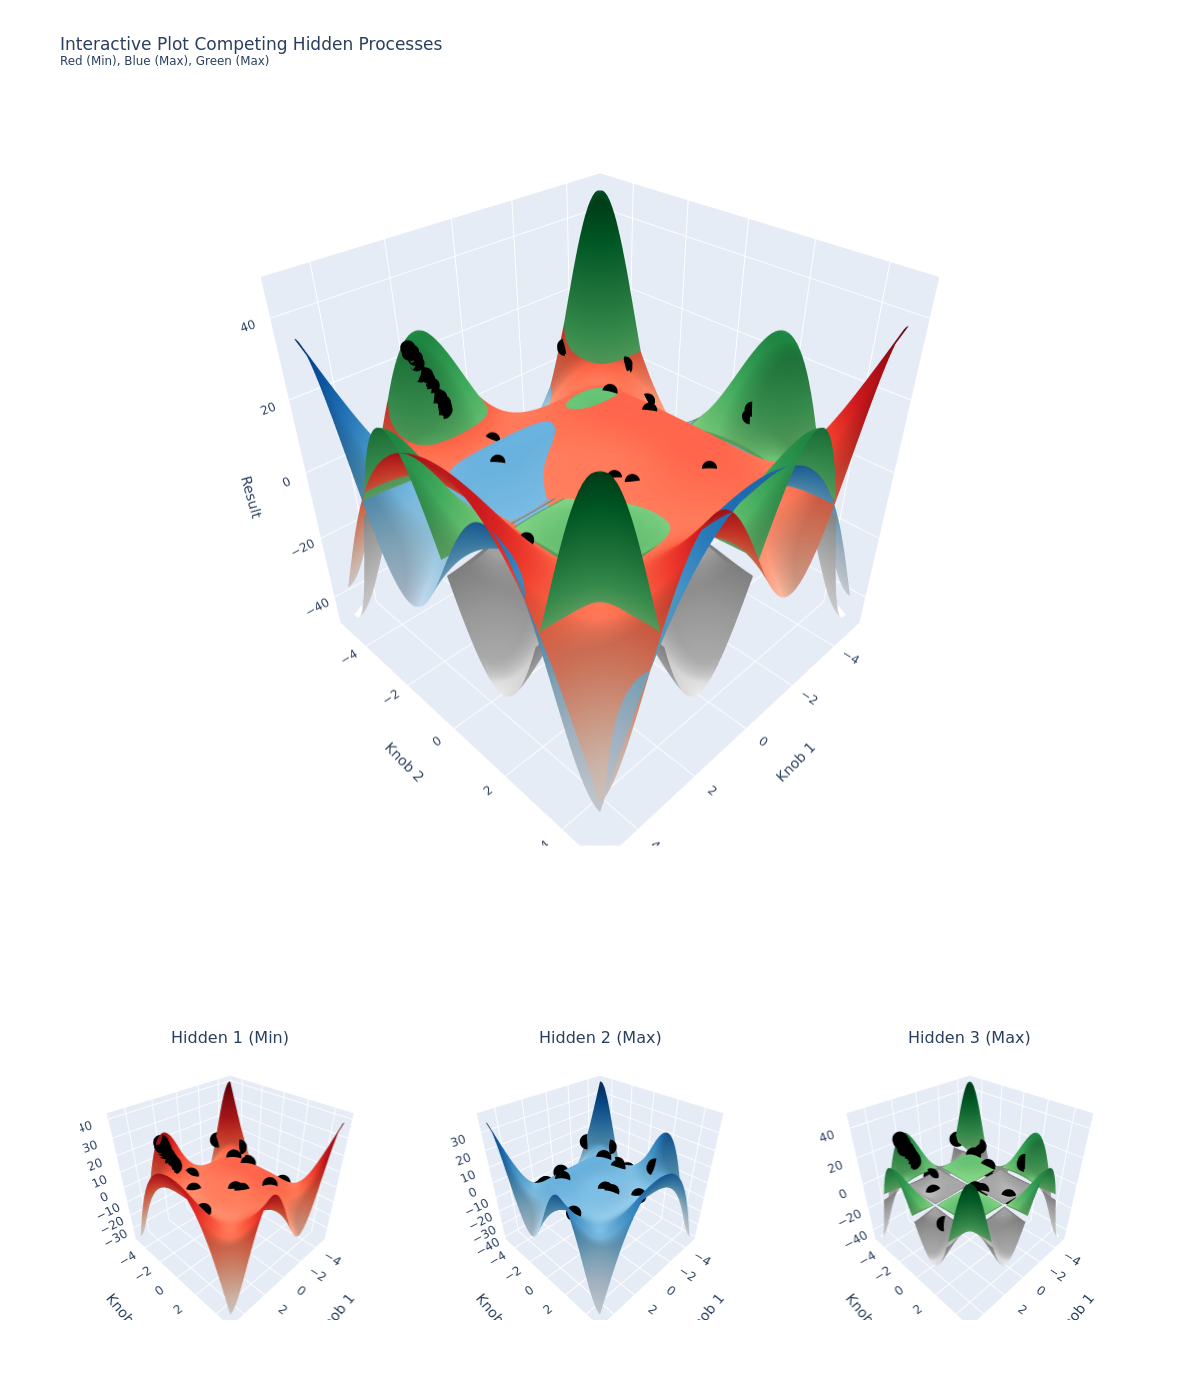

In [50]:
fig.show('png')

---
## Continue The Study

### Iterate Up To 75 Trials

Continue in batches of 1 up to 75 total trials:

In [51]:
n_trials

51

In [52]:
trial_count = 75
batch_size = 1

while n_trials < trial_count:
    # get suggestion(s)
    suggestions = vizier.suggest_trials(
        dict(
            parent = study.name,
            suggestion_count = batch_size,
            client_id = 'client_1'
        )
    ).result()

    # format suggestion
    trial_inputs = []
    for s in suggestions.trials:
        parms = dict(name = s.name)
        for p in s.parameters:
            parms[p.parameter_id] = p.value
        trial_inputs.append(parms)

    # evaluate suggestion
    trial_results = [
        dict(
            name = trial['name'],
            final_measurement = dict(
                metrics = process_evaluation(trial['knob_1'], trial['knob_2'])
            )
        ) for trial in trial_inputs
    ]

    # register result to study
    responses = [vizier.complete_trial(trial) for trial in trial_results]

    # increment counter
    n_trials += batch_size

### Get Optimal Trials

In [53]:
optimal_trials = vizier.list_optimal_trials(dict(parent = study.name))

In [54]:
len(optimal_trials.optimal_trials)

10

In [55]:
optimal_values = dict(
    names = [trial.name for trial in optimal_trials.optimal_trials],
    knob_1 = [trial.parameters[0].value for trial in optimal_trials.optimal_trials],
    knob_2 = [trial.parameters[1].value  for trial in optimal_trials.optimal_trials],
    red = [trial.final_measurement.metrics[0].value for trial in optimal_trials.optimal_trials],
    blue = [trial.final_measurement.metrics[1].value for trial in optimal_trials.optimal_trials],
    green = [trial.final_measurement.metrics[2].value for trial in optimal_trials.optimal_trials]
)

### Get All Trails

In [56]:
all_trials = vizier.list_trials(dict(parent = study.name))

In [57]:
len(all_trials.trials)

75

In [58]:
non_optimal_values = dict(
    names = [trial.name for trial in all_trials.trials if trial.name not in optimal_values['names']],
    knob_1 = [trial.parameters[0].value for trial in all_trials.trials if trial.name not in optimal_values['names']],
    knob_2 = [trial.parameters[1].value  for trial in all_trials.trials if trial.name not in optimal_values['names']],
    red = [trial.final_measurement.metrics[0].value for trial in all_trials.trials if trial.name not in optimal_values['names']],
    blue = [trial.final_measurement.metrics[1].value for trial in all_trials.trials if trial.name not in optimal_values['names']],
    green = [trial.final_measurement.metrics[2].value for trial in all_trials.trials if trial.name not in optimal_values['names']]    
)

In [59]:
len(non_optimal_values['names'])

65

### Add Trials To Visualization

In [ ]:
# Create the figure with subplots
fig = make_subplots(
    rows=3, cols=3,
    specs=[[{"is_3d": True, "colspan": 3, "rowspan": 2}, None, None], [None, None, None], [{"is_3d": True}, {"is_3d": True}, {"is_3d": True}]],
    subplot_titles=(None, "Hidden 1 (Min)", "Hidden 2 (Max)", "Hidden 3 (Max)"),
)

# Create the surface plots and add them to the subplots
fig.add_trace(surface1, row=1, col=1)
fig.add_trace(surface2, row=1, col=1)
fig.add_trace(surface3, row=1, col=1)
fig.add_trace(surface3b, row=1, col=1)
fig.add_trace(surface1, row=3, col=1)
fig.add_trace(surface2, row=3, col=2)
fig.add_trace(surface3, row=3, col=3)
fig.add_trace(surface3b, row=3, col=3)

# add trials: optimal
for k1, k2, r, b, g in zip(optimal_values['knob_1'], optimal_values['knob_2'], optimal_values['red'], optimal_values['blue'], optimal_values['green']):
    fig.add_trace(go.Scatter3d(x = [k1, k1, k1], y = [k2, k2, k2], z = [r, b, g], mode = 'lines+markers', line = dict(color = "#00ff00"), marker = dict(size = 5)), row=1, col=1)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [r], mode = 'lines+markers', line = dict(color = "#00ff00"), marker = dict(size = 5)), row=3, col=1)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [b], mode = 'lines+markers', line = dict(color = "#00ff00"), marker = dict(size = 5)), row=3, col=2)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [g], mode = 'lines+markers', line = dict(color = "#00ff00"), marker = dict(size = 5)), row=3, col=3)

# add trials: non-optimal
for k1, k2, r, b, g in zip(non_optimal_values['knob_1'], non_optimal_values['knob_2'], non_optimal_values['red'], non_optimal_values['blue'], non_optimal_values['green']):
    fig.add_trace(go.Scatter3d(x = [k1, k1, k1], y = [k2, k2, k2], z = [r, b, g], mode = 'lines+markers', line = dict(color = "#000000"), marker = dict(size = 5)), row=1, col=1)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [r], mode = 'lines+markers', line = dict(color = "#000000"), marker = dict(size = 5)), row=3, col=1)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [b], mode = 'lines+markers', line = dict(color = "#000000"), marker = dict(size = 5)), row=3, col=2)
    fig.add_trace(go.Scatter3d(x = [k1], y = [k2], z = [g], mode = 'lines+markers', line = dict(color = "#000000"), marker = dict(size = 5)), row=3, col=3)

# Update layout to add color bars to each subplot
fig.update_layout(
    scene1=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    scene2=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    scene3=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    scene4=dict(xaxis_title="Knob 1", yaxis_title="Knob 2", zaxis_title="Result"),
    showlegend=False,
    autosize=False,
    width=1200,  # Adjust width as needed
    height=1400,  # Adjust height as needed
    title="Interactive Plot Competing Hidden Processes<br><sup>Red (Min), Blue (Max), Green (Max)</sup>",
)

# Display the plot
fig.show()

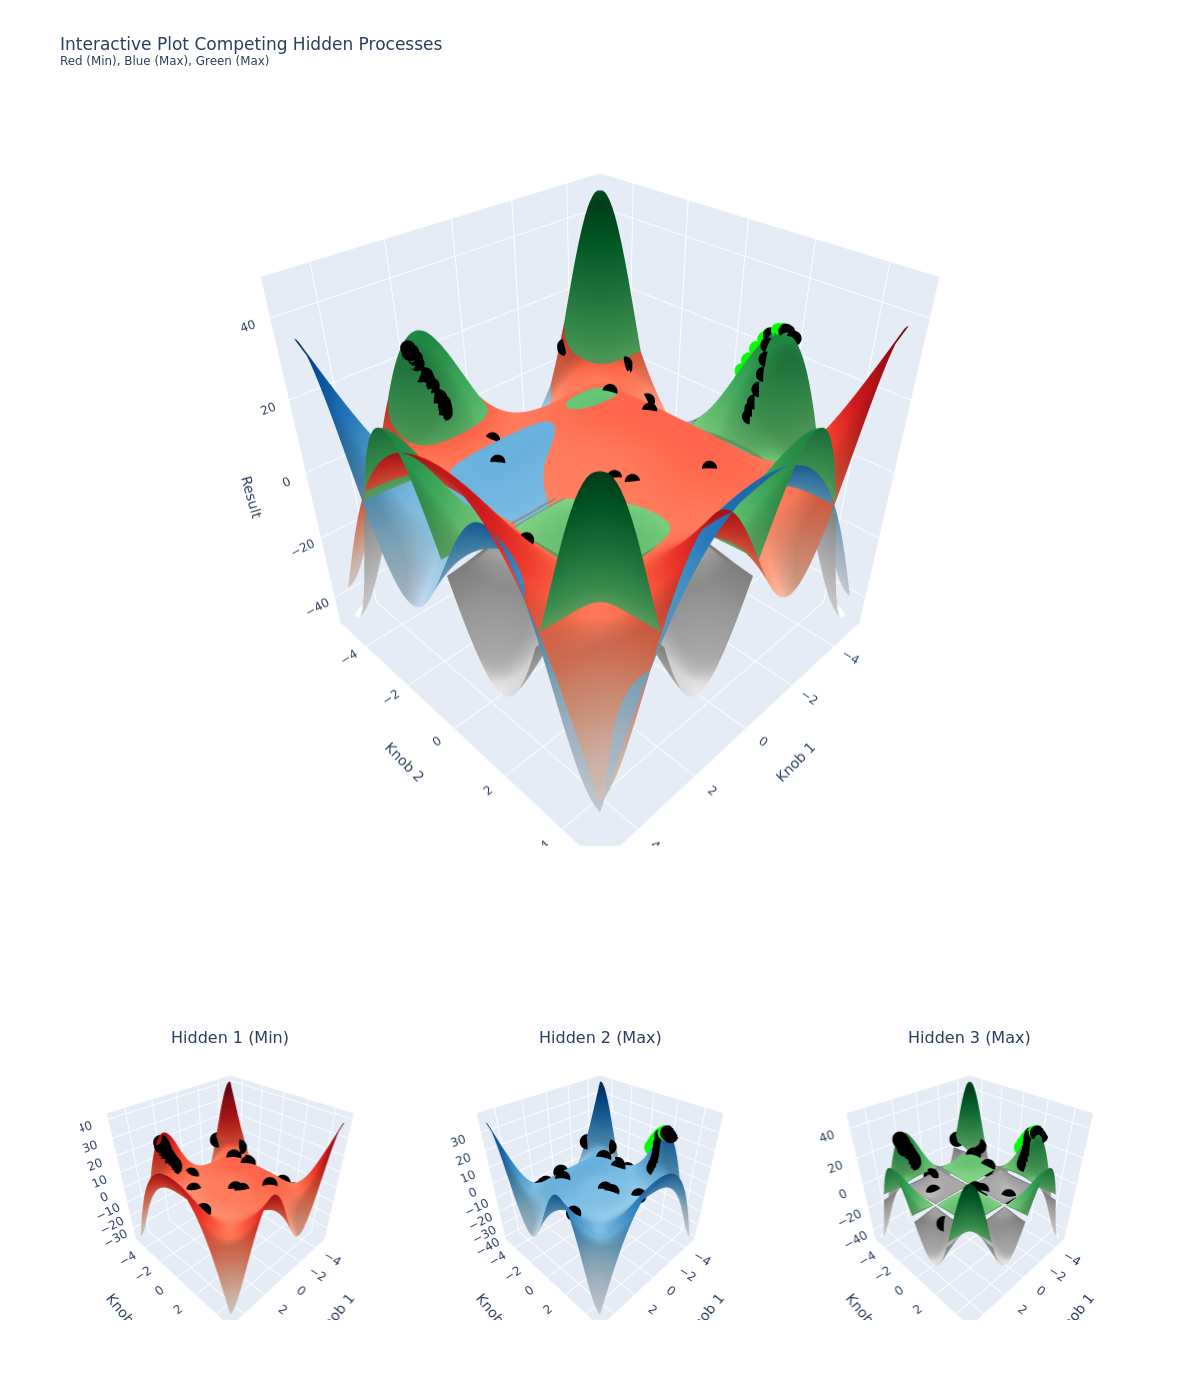

In [61]:
fig.show('png')

---
## Finish

### Save Study Trials Data Locally

In [62]:
get_trials = vizier.list_trials(dict(parent = study.name))

In [63]:
store_trials = [
    dict(
        parameters = [dict(parameter_id=p.parameter_id, value=p.value) for p in trial.parameters],
        final_measurement = dict(metrics=[dict(metric_id=m.metric_id, value=m.value) for m in trial.final_measurement.metrics])
    ) for trial in get_trials.trials
]

In [64]:
store_trials[0:2]

[{'parameters': [{'parameter_id': 'knob_1', 'value': -5.0},
   {'parameter_id': 'knob_2', 'value': 1.7077512281496485}],
  'final_measurement': {'metrics': [{'metric_id': 'red',
     'value': -15.589491651828428},
    {'metric_id': 'blue', 'value': 21.155637973829542},
    {'metric_id': 'green', 'value': 26.519064324377606}]}},
 {'parameters': [{'parameter_id': 'knob_1', 'value': -5.0},
   {'parameter_id': 'knob_2', 'value': 1.6450324084529084}],
  'final_measurement': {'metrics': [{'metric_id': 'red',
     'value': -16.076374142512105},
    {'metric_id': 'blue', 'value': 21.13545588790159},
    {'metric_id': 'green', 'value': 26.494907491902023}]}}]

In [65]:
with open(f"{DIR}/trials.jsonl", 'w') as f:
    for trial in store_trials:
        f.write(json.dumps(trial)+'\n')

In [66]:
with open(f"{DIR}/trials.jsonl", 'r') as f:
    reload_trials = [json.loads(line) for line in f]

In [67]:
store_trials==reload_trials

True

### Delete Study

Uncomment this section to delete the study from Vertex AI.

In [68]:
#vizier.delete_study(dict(name = study.name))